In [1]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

import datetime
from sys import getsizeof,path

import theano
import theano.tensor as tt
import pymc3 as pm
theano.config.optimizer="fast_run"

import matplotlib.pyplot as plt
import matplotlib

In [2]:
path.append("../src")
from Bundeslaender import Bundeslaender,Feiertage

In [3]:
def tt_lognormal(x, mu, sigma):
# Limit to prevent NANs
    x = tt.clip(x,1e-9,1e12)
    sigma = tt.clip(sigma,1e-9,1e12)
    mu = tt.clip(mu,1e-9,1e12)
    
    distr = 1/x * tt.exp( -( (tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0) + 1e-12)


In [4]:
feiertage = Feiertage()

startdate = datetime.datetime(2020,2,1)
enddate = datetime.datetime(2021,6,12)

fdays = feiertage.BundeslandArray(startdate,enddate)

In [5]:
fdays

<xarray.DataArray (BL: 16, status: 4, date: 498)>
array([[[False, False,  True, ...,  True, False, False],
        [False, False, False, ..., False,  True, False],
        [ True, False, False, ..., False, False,  True],
        [False,  True, False, ..., False, False, False]],

       [[False, False,  True, ...,  True, False, False],
        [False, False, False, ..., False,  True, False],
        [ True, False, False, ..., False, False,  True],
        [False,  True, False, ..., False, False, False]],

       [[False, False,  True, ...,  True, False, False],
        [False, False, False, ..., False,  True, False],
        [ True, False, False, ..., False, False,  True],
        [False,  True, False, ..., False, False, False]],

       ...,

       [[False, False,  True, ...,  True, False, False],
        [False, False, False, ..., False,  True, False],
        [ True, False, False, ..., False, False,  True],
        [False,  True, False, ..., False, False, False]],

       [[False, False,  True, ...,  True, False, False],
        [False, False, False, ..., False,  True, False],
        [ True, False, False, ..., False, False,  True],
        [False,  True, False, ..., False, False, False]],

       [[False, False,  True, ...,  True, False, False],
        [False, False, False, ..., False,  True, False],
        [ True, False, False, ..., False, False,  True],
        [False,  True, False, ..., False, False, False]]])
Coordinates:
  * BL       (BL) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * status   (status) <U14 'workday' 'friday' 'saturday' 'sunday/holiday'
  * date     (date) datetime64[ns] 2020-02-01 2020-02-02 ... 2021-06-12

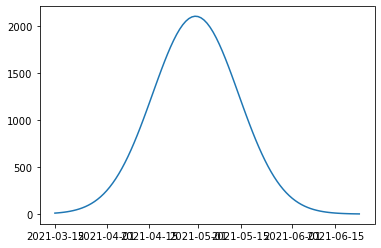

In [6]:
r = pow(2.5,.25)
deaths = [10]
for i in range(100):
    deaths.append(deaths[-1]*r)
    r = r*.995
    
drange = pd.date_range(datetime.date(2021,3,15),periods=len(deaths),freq="D")
xdeaths = xr.DataArray(deaths,dims=["date"],coords={"date":drange})

plt.plot(xdeaths.coords["date"],xdeaths)

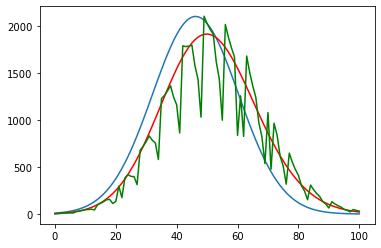

In [7]:
def StructuredDelays(mu,sigma,length):
    delay = tt_lognormal(tt.arange(0,length)+0.5,sigma,length)
    delay = delay.dimshuffle('x',0,'x','x')
    # date , delay-days , BL, age
    return delay

def RollDelays(delay,days):
    # date , delay , [...]
    fill = tt.stack([tt.zeros_like(delay[0])]*(days-1))
    delay = tt.concatenate([delay,fill],axis=0)
    for i in range(1,days):
        delay = tt.set_subtensor(delay[:,i,...],tt.roll(delay[:,i,...],i,axis=0))
    return delay

def UnRollDelays(delay,days):
    # date , delay , [...]
    fill = tt.stack([tt.zeros_like(delay[0])]*(days-1))
    delay = tt.concatenate([delay,fill],axis=0)
    for i in range(1,days):
        delay = tt.set_subtensor(delay[:,i,...],tt.roll(delay[:,i,...],i,axis=0))
    return delay
        
def DelayDeathsWeekday(deaths,days=28):
    delay = StructuredDelays(2.8,.8,days)
    
    exdeaths = tt.cast(deaths.values,"float64").dimshuffle(0,'x','x','x')
    delayed_deaths = exdeaths*delay
    delayed_deaths_date_aligned = RollDelays(delayed_deaths,days)
    
    edeaths = tt.sum(delayed_deaths_date_aligned,axis=[2,3]).eval()    
    dr = deaths.coords["date"].values
    
    feiertage = Feiertage()
    startdate = pd.Timestamp(dr[0])
    enddate = pd.Timestamp(dr[-1])+datetime.timedelta(days=days-1)
    xdays_bl = feiertage.BundeslandArray(startdate,enddate)[0,...] # Select 1 BL
    ex_xdays = tt.cast(xdays_bl,"float64").dimshuffle(1,0,'x','x')
    
    
    def Reporting_Delay_scan(delayed_deaths,day_status,delayed_bins,output_bins, in_weights,out_weights):
        # push bins 
        delayed_bins = tt.roll(delayed_bins,0)
        delayed_bins = tt.set_subtensor(delayed_bins[0],tt.zeros_like(delayed_bins[0]))
        # Calculate transfers
        w_in, w_out = tt.sum(day_status*in_weights,0), tt.sum(day_status*out_weights,0)
        t_in, t_out = delayed_deaths*w_in, delayed_bins*w_out
        # new state
        delayed_bins = delayed_bins - t_out + t_in
        output_bins = delayed_deaths - t_in + t_out
        
        return [delayed_bins,output_bins]
    
    seqs = [delayed_deaths_date_aligned,ex_xdays]
    out_info = [tt.zeros([days,1,1],dtype="float64"),tt.zeros([days,1,1],dtype="float64")]
    in_weights = tt.cast([.1,.2,.3,.5],"float64").dimshuffle(0,'x','x')
    out_weights = tt.cast([.3,.2,.2,.1],"float64").dimshuffle(0,'x','x')
    non_seqs = [in_weights,out_weights]
    outputs,updates = theano.scan(fn=Reporting_Delay_scan,sequences=seqs,outputs_info=out_info,non_sequences=non_seqs)
    output_bins = outputs[1][:-(days-1)]
  #  outputs = Reporting_Delay_scan(delayed_deaths_date_aligned[0],ex_xdays[0],tt.zeros([days,1,1],dtype="float64"),tt.zeros([days,1,1],dtype="float64"),in_weights,out_weights)
    

    return edeaths[:-(days-1)],output_bins
    
edeaths,output_bins = DelayDeathsWeekday(xdeaths)

plt.plot(xdeaths)
plt.plot(tt.sum(edeaths,axis=[1]).eval(),color="red")
plt.plot(tt.sum(output_bins,axis=[1,2,3]).eval(),color="green")

In [8]:
print(outputs)

NameError: name 'outputs' is not defined

In [16]:
# Test Date range
print(drange)

left = pd.date_range(end=drange[0],periods=5,freq="D",closed="left")
print(left)

#print(drange+5)
drange.memory_usage()

DatetimeIndex(['2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22',
               '2021-03-23', '2021-03-24',
               ...
               '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17',
               '2021-06-18', '2021-06-19', '2021-06-20', '2021-06-21',
               '2021-06-22', '2021-06-23'],
              dtype='datetime64[ns]', length=101, freq='D')
DatetimeIndex(['2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14'], dtype='datetime64[ns]', freq='D')


808